# Satellite Derived Bathymetry using the Stumpf Log-Regression Method for the Lake Mille Lacs Area of Interest

Author: Gregor Beyerle

Date: 2022-06-12

## Overview

This notebook contains the steps taken to perform SDB estimations for the L2A data product for this AOI. This includes:

- Loading the prepared data
- Setting up training and test data splits
- Calibrating the model
- Evaluating the model


Because Stumpf Log-Regression is usually used on bottom of the atmosphere reflectance values and I was not able to produce a valid Acolite product for this particular AOI (as mentioned in the [Lake Mille Lacs Dataset Preparation Notebook](./06__dataset_preparation_mille_lacs.ipynb)), I only perform SDB estimations for the L2A data product. This helps to at least set a baseline for exploring the LightGBM model later on.

In [1]:
import os
import sys
import dotenv

import eolearn
from eolearn.core import (
    FeatureType,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
    LoadTask
)
from eolearn.ml_tools import TrainTestSplitTask

import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import dalex as dx

This notebook uses functionality of both the `eolearn_extras` module as well as the `sdb_utils` module. It is important to add the relative location of the repository's root directory to the `sys.path` and import `eolearn_extras` before `sdb_utils` as some functions in this module reference `eolearn_extras`.

In [2]:
root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx
from sdb_utils.stumpf import get_stumpf_log_ratio
from sdb_utils.ml_utils import (
    create_sdb_estimation,
    get_X_y_for_split,
    SplitType,
)

The data for this project can - depending on whether you work with the complete dataset or only the preprocessed data - be roughly 13 GB on disk. This makes it necessary to distribute data individually from the repository and therefore the location of the data root directory might differ from setup to setup. This repository uses a `.env` file to configure the individual data root directory location. You need to add the `.env` file to your `notebooks` directory and add a line containing the needed information as a line following the pattern `data_root=<path-to-your-data-root>` in order for this notebook to work correctly.

In [3]:
dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

We already prepared the needed data for this AOI in previous notebooks. The first step of the workflow for preparing the train-test-split is to load it from disk.

In [4]:
mille_lacs_eop_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'mille_lacs_sentinel_merged')
)
load_mille_lacs_eop = LoadTask(mille_lacs_eop_path)

The eo-learn framework includes a `TrainTestSplitTask` which can be used to create a mask with an arbitrary amount of numerical class (e.g. train, validation and test) labels. For this AOI I decided to use 5% of all possible pixels for training. I did not want to use more samples because with the AOI not offering a very high degree of variance and the spatial resolution being relatively high, the danger of overfitting appears to be especially pressing. Also, even if in reality a field survey is unlikely to perform a uniform sampling over the whole AOI, I would like to perform an analysis that has some use for people that only have the possibility to survey a limited amount of point tracks when collecting their own calibration data.

In [5]:
data_feature = (FeatureType.MASK_TIMELESS, 'buffered_bathy_mask')
train_test_mask_feature = (FeatureType.MASK_TIMELESS, 'train_test_split')

train_test_split_task = TrainTestSplitTask(
    input_feature=data_feature,
    output_feature=train_test_mask_feature,
    bins=[0.05],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
)

The `TrainTestSplitTask` does not itself take an argument for masking out "uninteresting" pixels. Also, it does produce only one mask for all classes, which is - at times - cumbersome to use. I use the `AddValidTrainTestMasks` to combine the bathymetry data mask and the pixel locations of each split to their own masks.

In [6]:
valid_train_test_data_mask_task = eolx.ml_util.AddValidTrainTestMasks(
    train_test_maks_feature=train_test_mask_feature,
    valid_data_mask_feature=data_feature
)

The workflow for performing this preparation is comparatively simple as seen in the dependency graph below.

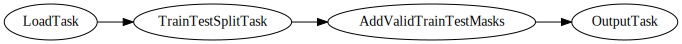

In [7]:
tt_wf_output_label = 'tt_wf_output'
output_task = OutputTask(tt_wf_output_label)

nodes = linearly_connect_tasks(
    load_mille_lacs_eop,
    train_test_split_task,
    valid_train_test_data_mask_task,
    output_task
)

read_merge_wf = EOWorkflow(nodes)

read_merge_wf.dependency_graph()

Without configuring a random seed to the `TrainTestSplitTask` the pixels in each split would differ with each execution. While this should not impact the analysis it would impair others to repeat the analysis and come to the exact same results. The `seed` argument has to be configured at execution time. To do this in the context of a workflow rather than a simple task execution we can find the `EONode` reference in the list of nodes which was implicitly created for us when we executed the `linearly_connected_tasks` function.

After executing the workflow we can see that we now have the required masks as well as some additional information in the `meta_info` that helps to gain an intuition for the magnitude of each supported split.

In [8]:
train_test_split_ref = [node for node in nodes if node.name == 'TrainTestSplitTask'][0]
read_merge_wf_res = read_merge_wf.execute(
    input_kwargs={
        train_test_split_ref: {'seed': 42}
    }
)

train_test_eop = read_merge_wf_res.outputs[tt_wf_output_label]
train_test_eop

EOPatch(
  data={
    L1C_data: numpy.ndarray(shape=(1, 2871, 2794, 13), dtype=float32)
    L2A_data: numpy.ndarray(shape=(1, 2871, 2794, 12), dtype=float32)
    L2R_data: numpy.ndarray(shape=(1, 2871, 2794, 11), dtype=float32)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
    buffered_bathy_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
    test_split_valid: numpy.ndarray(shape=(2871, 2794, 1), dtype=int32)
    train_split_valid: numpy.ndarray(shape=(2871, 2794, 1), dtype=int32)
    train_test_split: numpy.ndarray(shape=(2871, 2794, 1), dtype=int64)
  }
  meta_info={
    test_count: 4880210
    test_perc: 0.9500677186137317
    train_count: 256487
    train_perc: 0.049932281386268255
    validation_count: 0
    validation_perc: 0.0
  }
  bbox=BBox(((436481.2917158468, 5106398.21482021), (464421.2917158468, 5135108.21482021)), crs=CRS('32615'

## Performing SDB on the Basis of L2A Data

To calibrate the model we have to retrieve the "label values" (true bathymetry values) first.

In [9]:
buffered_bathy_mask_feature = (FeatureType.MASK_TIMELESS, 'buffered_bathy_mask')
_, y_train = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Train,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature=buffered_bathy_mask_feature
)

In a common regression scenario I would take some or all band values for a pixel location as the explanatory variables. If we look at the formula for the Stumpf method it becomes clearer why we would take another approach.

$$
Z = m_1\frac{ln(nR_w(\lambda_i))}{ln(nR_w(\lambda_j))} - m_0
$$

In other terms we can interpret $Z$ as the estimated bathymetry value (or the $\hat{y}$ of the regression), $n$ as a given constant that is used to force a positive value for the logarithm, the function $R_w$ as the reflectance value for a given $\lambda$, $m_0$ as the calibrated regression intercept and $m_1$ as the calibrated regression coefficient (Stumpf et al., 2003).

If we want to to stay within this mathematical notation the data for `X_train` returned by `get_stumpf_log_ratio` could be described as

$$
X_{train} = \frac{ln(nR_w(\lambda_i))}{ln(nR_w(\lambda_j))}
$$

where $R_w(\lambda_i)$ corresponds to the blue band and $R_w(\lambda_j)$ corresponds to the green band.

In [10]:
train_mask_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')], axis=-1)
X_train = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, 'L2A_data'), train_mask_single_band)

With the data in place the rest of the modelling process boils down to just fitting a linear model. We can use the scikit-learn framework to fit a linear regression.

In [11]:
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

As we are estimating pixel values for a bathymetry map we can generate estimates for the whole map to visualize the model output. In the below cell we retrieve all valid explanatory data to produce a completely estimated map. While showing a far "grainier" picture than the ground truth image we see a picture that successfully captured the general features of the bathymetric profile of the AOI.

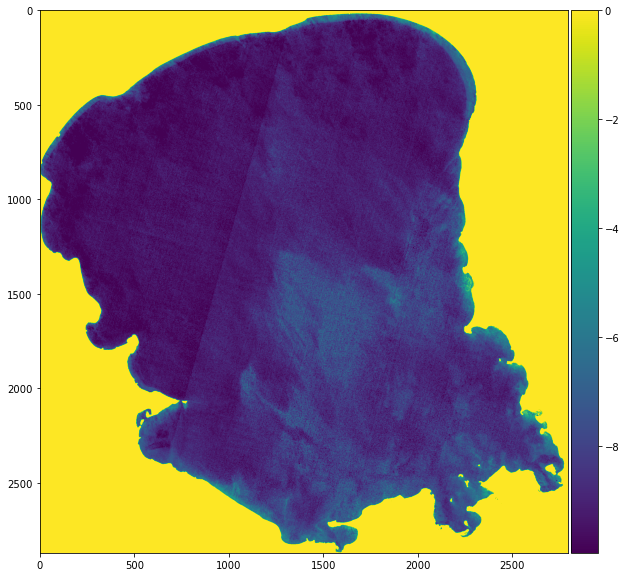

In [12]:
mask_complete_single_band = np.squeeze(train_test_eop[buffered_bathy_mask_feature], axis=-1)
X_all = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, 'L2A_data'), mask_complete_single_band)

l2a_sdb_estimation_values, l2a_sdb_estimation_map = create_sdb_estimation(train_test_eop, reg, X_all, mask_feature=buffered_bathy_mask_feature)
eolx.visualization.plot_ndarray_band(l2a_sdb_estimation_map, cmap='viridis')
plt.show()

When we visualize the estimation errors using a similar visualization we can see that the model underestimates the depth in particularly deep regions while overestimating some finer and shallower features.

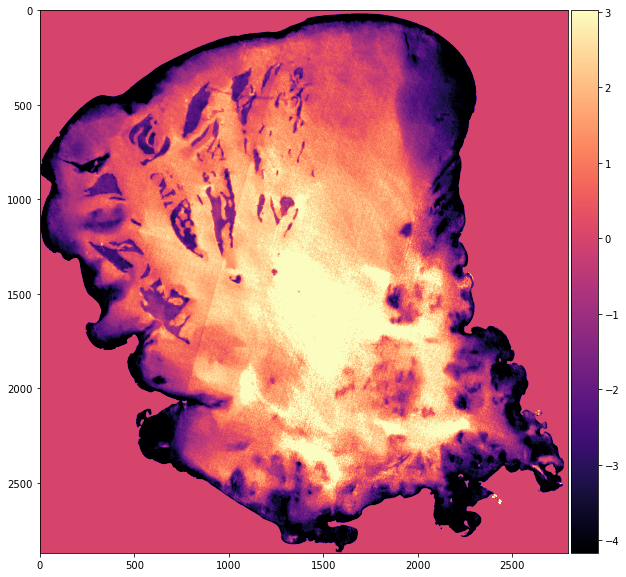

In [13]:
buffered_bathy_value_idx = train_test_eop[buffered_bathy_mask_feature] == 1
masked_true_value_map = np.zeros(train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')].shape)
masked_true_value_map[buffered_bathy_value_idx] =  train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')][buffered_bathy_value_idx]

l2a_sdb_errors = l2a_sdb_estimation_map - masked_true_value_map
eolx.visualization.plot_ndarray_band(l2a_sdb_errors, cmap='magma')
plt.show()

We can perform simple diagnostics for the linear regression by calculating the residuals and looking at their distribution. While there are long tails (especially to the right), almost all residuals span a range of -10 to 5 meters.

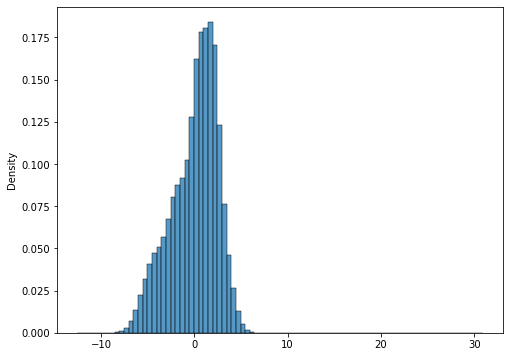

In [14]:
_, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
    data_mask_feature=buffered_bathy_mask_feature
)

fig, ax = plt.subplots(figsize=(8, 6))
l2a_sdb_residuals = l2a_sdb_estimation_values - y_all
sns.histplot(l2a_sdb_residuals, binwidth=0.5, stat='density', ax=ax)
plt.show()

Plotting the estimated values against the true bathymetry values shows that there is clearly visible linear between the estimated and actual depth values. The artifact for bathymetry values at zero meters of depth can be explained by a similar fragment in the ground truth values.

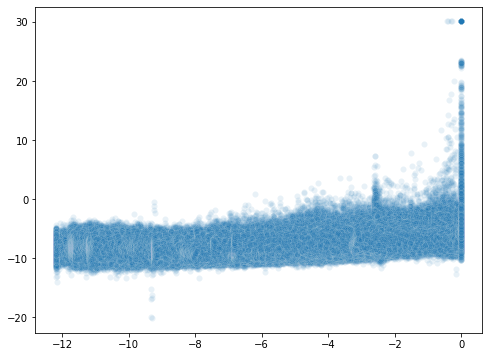

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_all, y=l2a_sdb_estimation_values, alpha=0.1, ax=ax)
plt.show()

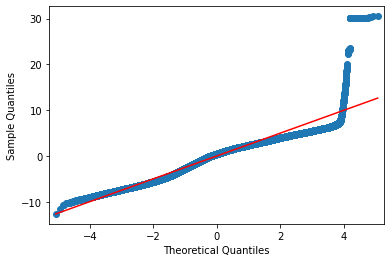

In [16]:
sm.qqplot(l2a_sdb_residuals, line='s')
plt.show()

In [17]:
import warnings
# avoid showing warnings for feature names
warnings.filterwarnings('ignore')

exp_stumpf_l2a = dx.Explainer(reg, X_all, y_all, label='stumpf_tuned_l2a', verbose=False)
exp_stumpf_l2a.model_performance()

,mse,rmse,r2,mae,mad
stumpf_tuned_l2a,6.2104,2.492067,0.160672,2.014791,1.769975
